DeepFilm: 基于深度学习和高质量数据集的胶片模型

---

下载数据集

In [ ]:
!mkdir data

In [ ]:
!curl 'https://my.microsoftpersonalcontent.com/personal/7d927b55396028ec/_layouts/15/download.aspx?UniqueId=fe2ca89e-4cef-4dc8-ad9a-45c89e06139e&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiIyMGExZmQ5MC1kMWUzLTQzM2EtOGZiYy0zZWM0OGY4ODkzMjgiLCJhcHBpZCI6IjAwMDAwMDAwLTAwMDAtMDAwMC0wMDAwLTAwMDA0ODE3MTBhNCIsImF1ZCI6IjAwMDAwMDAzLTAwMDAtMGZmMS1jZTAwLTAwMDAwMDAwMDAwMC9teS5taWNyb3NvZnRwZXJzb25hbGNvbnRlbnQuY29tQDkxODgwNDBkLTZjNjctNGM1Yi1iMTEyLTM2YTMwNGI2NmRhZCIsImV4cCI6IjE3MzcxNzgwOTEifQ.8V7n0yRjX50i4Ovb859GbR2okA4mgekhZkB90AfuUNK_VMBejLbeDifdWS79hz4iSSkb1bKLmbIRDGh1DiB8vo6Ua18ByRc2qVXl_aEeh8_SuqOhRIcgvMDmv6OtfETGNcmpgCxviq9s3W2RZ47rYEDfLL5xLxzw35PqJIvUri2zrUUabIDtmHyLkJz1lnJvLJGooVKi2DdipxrzR3EQ9l_DAZkJgp0Sun8xz0BrhlIAP4C9cHXgBwKyCM2Lqun8UJrO_ZHiCpAH7FuO_e-ecTyZlOChI7EHAmilqjuqbsp8kvPY8xB5ao3Ema-0wePGurg7zm1eq8v5JIxeuZzSYOOAE-1qn8yGazdqgmFeOCb9_SLGQdmEynSRi6gE1bP0FfI6V3gDTLGjU34SFn5Fbw.j_5zrdMPEgOB71gqZCqU1vBbrb-W2RUWTVWbmI39rIY&ApiVersion=2.0&AVOverride=1' \
  -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7' \
  -H 'accept-language: zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6' \
  -H 'cookie: MicrosoftApplicationsTelemetryDeviceId=1df3ef1f-eafc-4dc7-bba7-7bf057982f4e; MSFPC=GUID=7eabda162e7e4041935b7b2f47a39ce0&HASH=7eab&LV=202412&V=4&LU=1733038721174; ai_session=ZZpNnpkd/ZKLuS/KaylRjg|1737174464453|1737174464468' \
  -H 'priority: u=0, i' \
  -H 'referer: https://onedrive.live.com/' \
  -H 'sec-ch-ua: "Microsoft Edge";v="131", "Chromium";v="131", "Not_A Brand";v="24"' \
  -H 'sec-ch-ua-mobile: ?1' \
  -H 'sec-ch-ua-platform: "Android"' \
  -H 'sec-fetch-dest: iframe' \
  -H 'sec-fetch-mode: navigate' \
  -H 'sec-fetch-site: cross-site' \
  -H 'sec-fetch-user: ?1' \
  -H 'upgrade-insecure-requests: 1' \
  -H 'user-agent: Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Mobile Safari/537.36 Edg/131.0.0.0'\
  --output data/dig_film.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4707M  100 4707M    0     0  33.1M      0  0:02:21  0:02:21 --:--:-- 32.6M


In [ ]:
!unzip data/dig_film.zip -d data

Archive:  data/dig_film.zip
   creating: data/胶片-数码/
   creating: data/胶片-数码/伪胶片/
  inflating: data/胶片-数码/伪胶片/1.jpg  
  inflating: data/胶片-数码/伪胶片/10.jpg  
  inflating: data/胶片-数码/伪胶片/100.jpg  
  inflating: data/胶片-数码/伪胶片/101.jpg  
  inflating: data/胶片-数码/伪胶片/102.jpg  
  inflating: data/胶片-数码/伪胶片/103.jpg  
  inflating: data/胶片-数码/伪胶片/104.jpg  
  inflating: data/胶片-数码/伪胶片/105.jpg  
  inflating: data/胶片-数码/伪胶片/106.jpg  
  inflating: data/胶片-数码/伪胶片/107.jpg  
  inflating: data/胶片-数码/伪胶片/108.jpg  
  inflating: data/胶片-数码/伪胶片/109.jpg  
  inflating: data/胶片-数码/伪胶片/11.jpg  
  inflating: data/胶片-数码/伪胶片/110.jpg  
  inflating: data/胶片-数码/伪胶片/111.jpg  
  inflating: data/胶片-数码/伪胶片/112.jpg  
  inflating: data/胶片-数码/伪胶片/113.jpg  
  inflating: data/胶片-数码/伪胶片/114.jpg  
  inflating: data/胶片-数码/伪胶片/115.jpg  
  inflating: data/胶片-数码/伪胶片/116.jpg  
  inflating: data/胶片-数码/伪胶片/117.jpg  
  inflating: data/胶片-数码/伪胶片/118.jpg  
  inflating: data/胶片-数码/伪胶片/119.jpg  
  inflating: data/胶片-数码/伪胶片/12.jpg  
  inflating

训练胶片风格到数码风格的转换（柯达金200转换到数码风格）的模型。

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import tqdm
import math
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    print("GPU可用！")
else:
    print("GPU不可用，将使用CPU进行计算。")

GPU可用！


In [3]:
class ImagePairDataset(Dataset):
    def __init__(self, folder1, folder2, pairs, transform=None):
        self.folder1 = folder1
        self.folder2 = folder2
        self.pairs = pairs
        self.transform = transform
        self.image_pairs = self.read_image_pairs()

    def read_image_pairs(self):
      image_pairs = []
      for image_pair in tqdm.tqdm(self.pairs):
        img1_path = os.path.join(self.folder1, image_pair[0])
        img2_path = os.path.join(self.folder2, image_pair[1])
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        image_pairs.append((img1, img2))
      return image_pairs
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
      return self.image_pairs[idx][0], self.image_pairs[idx][1]

In [4]:
def show_paired_images(dataset, batch_size=4):
  # Create DataLoader
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  for img1, img2 in dataloader:
    # Convert tensor to numpy for plotting
    img1 = img1.permute(0, 2, 3, 1).numpy()  # Change to (batch_size, height, width, channels)
    img2 = img2.permute(0, 2, 3, 1).numpy()

    # Plot pairs of images
    fig, axes = plt.subplots(batch_size, 2, figsize=(8, batch_size * 4))
    for i in range(batch_size):
      axes[i, 0].imshow(img1[i])
      axes[i, 0].axis('off')  # Hide axes
      axes[i, 0].set_title(f"Image 1 - Pair {i+1}")

      axes[i, 1].imshow(img2[i])
      axes[i, 1].axis('off')  # Hide axes
      axes[i, 1].set_title(f"Image 2 - Pair {i+1}")

    plt.tight_layout()
    plt.show()
    break  # Show only one batch for simplicity

In [8]:
# Define paths to the folders
digital_dir = "/root/autodl-tmp/胶片-数码/数码"
film_dir = "/root/autodl-tmp/胶片-数码/伪胶片"

In [9]:
# Get the list of files in both folders
digital = sorted(os.listdir(digital_dir))
film = sorted(os.listdir(film_dir))

print(len(digital))
print(len(film))

# Ensure the number of files match
if len(digital) != len(film):
    raise ValueError("The two folders must have the same number of images.")

# Create pairs of images (file1, file2)
pairs = list(zip(digital, film))

# Split into training and testing sets
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

825
825


In [10]:
# Define transformations (if needed)
transform = transforms.Compose([
  transforms.Resize((200, 320)),
  transforms.ToTensor()
])

In [11]:
batch_size = 8

In [12]:
# Create datasets
train_dataset = ImagePairDataset(digital_dir, film_dir, train_pairs, transform=transform)
test_dataset = ImagePairDataset(digital_dir, film_dir, test_pairs, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

100%|██████████| 165/165 [00:15<00:00, 10.90it/s]


In [42]:
# 通道注意力机制 (Channel Attention Mechanism)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

# 空间注意力机制 (Spatial Attention Mechanism)
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size // 2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x) * x

# 主网络
class ImageToImageCNN(nn.Module):
    def __init__(self):
        super(ImageToImageCNN, self).__init__()
        # 编码器部分 (使用卷积层)
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.ca1 = ChannelAttention(64)  # 添加通道注意力

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.ca2 = ChannelAttention(128)  # 添加通道注意力

        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.ca3 = ChannelAttention(256)  # 添加通道注意力

        # 解码器部分 (使用反卷积层)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=8, stride=4, padding=2, output_padding=0),
            nn.ReLU()
        )
        self.sa1 = SpatialAttention()  # 添加空间注意力

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(65, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU()
        )
        self.sa2 = SpatialAttention()  # 添加空间注意力

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(4, 32, kernel_size=2, stride=2, padding=0, output_padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.apply(self.init_weights)

    def init_weights(self, m):
        """ 使用 Kaiming 初始化卷积层的权重 """
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # 编码器部分
        enc1 = self.encoder1(x)
        enc1 = self.ca1(enc1)  # 添加通道注意力

        enc2 = self.encoder2(enc1)
        enc2 = self.ca2(enc2)  # 添加通道注意力

        enc3 = self.encoder3(enc2)
        enc3 = self.ca3(enc3)  # 添加通道注意力

        # 解码器部分
        dec1 = self.decoder1(enc3)
        dec1 = self.sa1(dec1)  # 添加空间注意力

        dec2 = self.decoder2(torch.cat([dec1, enc1], dim=1))
        dec2 = self.sa2(dec2)  # 添加空间注意力

        dec3 = self.decoder3(torch.cat([dec2, x], dim=1))
        return dec3

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [44]:
model = ImageToImageCNN()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # 损失函数

TypeError: ChannelAttention.__init__() missing 1 required positional argument: 'in_channels'

In [41]:
net = model

for param_tensor in net.state_dict():
  print(param_tensor, '\t', net.state_dict()[param_tensor].size())

encoder1.0.weight 	 torch.Size([64, 3, 4, 4])
encoder1.0.bias 	 torch.Size([64])
ca1.fc.0.weight 	 torch.Size([4, 64, 1, 1])
ca1.fc.2.weight 	 torch.Size([64, 4, 1, 1])
encoder2.0.weight 	 torch.Size([128, 64, 4, 4])
encoder2.0.bias 	 torch.Size([128])
ca2.fc.0.weight 	 torch.Size([8, 128, 1, 1])
ca2.fc.2.weight 	 torch.Size([128, 8, 1, 1])
encoder3.0.weight 	 torch.Size([256, 128, 4, 4])
encoder3.0.bias 	 torch.Size([256])
encoder3.1.weight 	 torch.Size([256])
encoder3.1.bias 	 torch.Size([256])
encoder3.1.running_mean 	 torch.Size([256])
encoder3.1.running_var 	 torch.Size([256])
encoder3.1.num_batches_tracked 	 torch.Size([])
ca3.fc.0.weight 	 torch.Size([16, 256, 1, 1])
ca3.fc.2.weight 	 torch.Size([256, 16, 1, 1])
decoder1.0.weight 	 torch.Size([256, 128, 8, 8])
decoder1.0.bias 	 torch.Size([128])
sa1.conv.weight 	 torch.Size([1, 2, 7, 7])
decoder2.0.weight 	 torch.Size([65, 64, 4, 4])
decoder2.0.bias 	 torch.Size([64])
sa2.conv.weight 	 torch.Size([1, 2, 7, 7])
decoder3.0.weight 

In [37]:
# 训练模型
num_epochs = 300

with tqdm.tqdm(total=num_epochs, desc="进度条") as pbar:
    for epoch in range(num_epochs):
        for i, (img1, img2) in enumerate(train_loader):
            img1, img2 = img1.to(device), img2.to(device)

            optimizer.zero_grad()
            output = model(img2)

            loss = criterion(output, img1)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())

        pbar.update(1)

进度条:   0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [3, 8, 4, 4], expected input[8, 1, 400, 640] to have 8 channels, but got 1 channels instead

In [18]:
def psnr(target, prediction, max_pixel=1.0):
    mse = torch.nn.functional.mse_loss(target, prediction)
    if mse == 0:
        return float('inf')  # 如果 MSE 为 0，意味着两图完全相同
    return 20 * math.log10(max_pixel / math.sqrt(mse))

def evaluate_psnr(data_loader, model, max_pixel=1.0):
    total_psnr = 0.0
    num_images = 0

    # 遍历数据集
    for generated_images, original_images in data_loader:
        # 确保输入输出图像在相同的设备上（例如：GPU）
        original_images = original_images.to(device)
        generated_images = generated_images.to(device)

        # 计算每一对图像的 PSNR
        for orig, gen in zip(original_images, generated_images):
            orig = orig.unsqueeze(0).cuda()  # 增加批量维度
            output = model(orig)
            psnr_value = psnr(gen, output[0], max_pixel=max_pixel)
            total_psnr += psnr_value
            num_images += 1

    # 计算整个数据集的平均 PSNR
    avg_psnr = total_psnr / num_images if num_images > 0 else 0.0
    return avg_psnr

In [19]:
avg_psnr = evaluate_psnr(test_loader, model)
print(f'Average PSNR for the dataset: {avg_psnr:.2f} dB')

Average PSNR for the dataset: 20.40 dB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13211693..0.9987907].


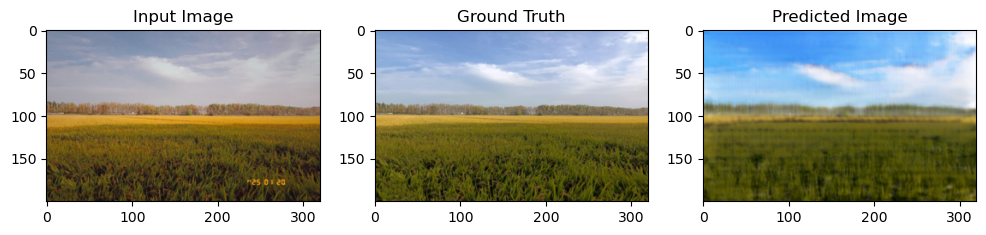

In [27]:
# 测试阶段：展示结果
model.eval()
with torch.no_grad():
    img1, img2 = test_dataset[154]  # 取一个示例
    img1 = img1.unsqueeze(0).cuda()  # 增加批量维度
    output = model(img1)

    # 将结果从 Tensor 转换回图片
    output_img = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img2 = img2.numpy().transpose(1, 2, 0)

    # 使用 matplotlib 显示图片
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img2)
    axes[0].set_title("Input Image")
    axes[1].imshow(img1)
    axes[1].set_title("Ground Truth")
    axes[2].imshow(output_img)
    axes[2].set_title("Predicted Image")
    plt.show()

由训练的模型，将真实胶片照片转换为数码风格的照片以便后面训练数码至胶片转换的模型。

---

训练数码至胶片（柯达金200）风格转换的模型。

---